In [1]:
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import math
from IPython.display import clear_output
from tqdm import tqdm

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None

In [3]:
times=[]
with open('timelist.txt', 'r') as fp:
    for line in fp:
        times.append(line[:-1])

nodates=[]
with open('nodatelist.txt', 'r') as fp:
    for line in fp:
        nodates.append(line[:-1])

In [4]:
bniftyu = pd.read_csv('BNF_2010_2020.csv',low_memory=False,on_bad_lines='skip')

In [5]:
bniftyu[bniftyu.Date==20180608]

,Instrument,Date,Time,Open,High,Low,Close
776839,BANKNIFTY,20180608,09:08,26457.3,26457.3,26457.3,26457.3
776840,BANKNIFTY,20180608,09:16,26463.5,26463.8,26374.0,26400.1
776841,BANKNIFTY,20180608,09:17,26401.4,26401.4,26343.1,26350.7
776842,BANKNIFTY,20180608,09:18,26352.8,26357.4,26334.1,26357.3
776843,BANKNIFTY,20180608,09:19,26358.3,26367.7,26350.8,26364.2
...,...,...,...,...,...,...,...
777211,BANKNIFTY,20180608,15:27,26448.3,26451.8,26446.2,26450.2
777212,BANKNIFTY,20180608,15:28,26450.8,26451.3,26443.8,26445.2
777213,BANKNIFTY,20180608,15:29,26445.0,26447.6,26437.7,26438.3
777214,BANKNIFTY,20180608,15:30,26438.2,26459.6,26432.8,26447.2


In [6]:
bnifty = pd.read_csv('banknifty_master.csv',low_memory=False,header=None,on_bad_lines='skip',names=["Strike", "Date", "Time", "Open","High","Low","Close","Volume"])
bnifty = bnifty[bnifty['Time'].isin(times)]
bnifty = bnifty[(bnifty.Date >= '2018/05/02') & (bnifty.Date <= '2020/02/14')]
bnifty = bnifty[~bnifty['Date'].isin(nodates)]
bnifty.reset_index(inplace=True)
bnifty.drop('index',axis=1,inplace=True)
bniftyeod = pd.read_csv('BNF_2018_2020_EOD.csv')[::-1]
bniftyeod['Date'] = pd.to_datetime(bniftyeod.Date)
bniftyeod['Date'] = bniftyeod['Date'].astype(str)
bniftyeod['Date'] = bniftyeod['Date'].apply(lambda line:line.replace('-', '/'))
bniftyeod = bniftyeod[~bniftyeod['Date'].isin(nodates)]
bniftyeod.reset_index(inplace=True)
bniftyeod.drop('index',axis=1,inplace=True)
bniftyu = pd.read_csv('BNF_2010_2020.csv',low_memory=False,on_bad_lines='skip')
bniftyu = bniftyu[(bniftyu.Date >= 20180502) & (bniftyu.Date <=20200214)]
bniftyu = bniftyu[bniftyu['Time'].isin(times)]
bniftyu['Date'] = bniftyu['Date'].astype(str)
bniftyu['Date'] = bniftyu['Date'].apply(lambda x:x[:4]+'/'+x[4:6]+'/'+x[6:])
# missingdates = list(set(bniftyu['Date']) - set(bnifty['Date']))
# missingdates=missingdates+['2019/04/24','2020/02/18','2020/03/13','2020/03/23']
bniftyu = bniftyu[~bniftyu['Date'].isin(nodates)]
bniftyu.reset_index(inplace=True)
bniftyu.drop('index',axis=1,inplace=True)

In [7]:
csbnifty = pd.DataFrame(columns=['Strike','Date','Time','Open','High','Low','Close'])
psbnifty = pd.DataFrame(columns=['Strike','Date','Time','Open','High','Low','Close'])
psbnifty=bnifty.groupby(['Date','Time']).nth([3])
csbnifty=bnifty.groupby(['Date','Time']).nth([4])
psbnifty.reset_index(inplace=True)
csbnifty.reset_index(inplace=True)

In [8]:
pivots = pd.DataFrame(columns=['Date','PP','BC','TC','R1','R2','R3','S1','S2','S3'])
pivots['Date']=bniftyeod['Date'].shift(-1)
pivots.drop(417,inplace=True)

In [9]:
pivots['PP'] = (bniftyeod['High']+bniftyeod['Low']+bniftyeod['Close'])/3
pivots['BC'] = (bniftyeod['High']+bniftyeod['Low'])/2
pivots['TC'] = pivots['PP']-pivots['BC']+pivots['PP']
pivots['R1'] = pivots['PP']*2-bniftyeod['Low']
pivots['R2'] = pivots['PP'] + bniftyeod['High'] - bniftyeod['Low']
pivots['R3'] = bniftyeod['High'] - 2*bniftyeod['Low'] + 2*pivots['PP']
pivots['S1'] = pivots['PP']*2-bniftyeod['High']
pivots['S2'] = pivots['PP'] - bniftyeod['High'] + bniftyeod['Low']
pivots['S3'] = bniftyeod['Low'] - 2*bniftyeod['High'] + 2*pivots['PP']
pivots.index = list(range(1,418))

In [10]:
bniftyeod

,Date,Open,High,Low,Close
0,2018/05/02,25607.05,25716.75,25499.35,25568.30
1,2018/05/03,25547.90,25653.45,25469.05,25605.25
2,2018/05/04,25632.30,25680.40,25537.70,25645.40
3,2018/05/07,25676.25,25913.50,25675.15,25852.05
4,2018/05/08,26074.15,26116.25,25954.60,26090.50
...,...,...,...,...,...
413,2020/02/10,31248.65,31248.80,30957.20,31058.15
414,2020/02/11,31230.20,31505.95,31225.90,31300.60
415,2020/02/12,31441.15,31588.60,31398.15,31492.90
416,2020/02/13,31586.55,31649.45,31180.60,31230.25


In [19]:
bniftyu[(bniftyu['Date']=='2018/05/02') & (bniftyu['Time']=='09:45')]['Close'].iloc[0]

25588.9

In [142]:
c=0
profp=[]
lossp=[]
def buy(d,tgt,sl):
    global c,profp,lossp
    c=c+1
    byp=bniftyu[(bniftyu['Date']==d) & (bniftyu['Time']=='09:20')]['Close'].iloc[0]
    for k in bniftyu['Time'].unique():
        if ((bniftyu[(bniftyu['Date']==d) & (bniftyu['Time']==k)]['Close']-sl)<0).iloc[0]:
            print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f} Long Stoploss hit!'.format(d,tgt,sl))
            lossp.append(100*(byp-sl)/byp)
            return sl
        if ((bniftyu[(bniftyu['Date']==d) & (bniftyu['Time']==k)]['High']-tgt)>0).iloc[0]:
            print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f} Long Target hit!'.format(d,tgt,sl))
            profp.append(100*(tgt-byp)/byp)
            return tgt
    print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f}  Time out!'.format(d,tgt,sl))
    return byp#(bniftyu[(bniftyu['Date']==d) & (bniftyu['Time']=='15:25')]['Close']).iloc[0]

def sell(d,sl,tgt):
    global c,profp,lossp
    c=c+1
    slp=bniftyu[(bniftyu['Date']==d) & (bniftyu['Time']=='09:20')]['Open'].iloc[0]
    for k in bniftyu['Time'].unique():
        if ((bniftyu[(bniftyu['Date']==d) & (bniftyu['Time']==k)]['Close']-tgt)<0).iloc[0]:
            print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f} Short Target hit!'.format(d,tgt,sl))
            profp.append(100*(slp-tgt)/slp)
            return tgt
        if ((bniftyu[(bniftyu['Date']==d) & (bniftyu['Time']==k)]['Close']-sl)>0).iloc[0]:
            print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f} Short Stoploss hit!'.format(d,tgt,sl))
            lossp.append(100*(sl-slp)/slp)
            return sl
    print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f}  Time out!'.format(d,tgt,sl))
    return slp#(bniftyu[(bniftyu['Date']==d) & (bniftyu['Time']=='15:25')]['Close']).iloc[0]

flag=0
profit=0
loss=0
a=0
ini=100000
balance=ini
minbalance=ini
maxbalance=0
bal=[]
tgt1=0
sl1=0
c1=0
for i in range(1,bniftyu.Date.nunique()):
    bal.append(balance)
    profit=0
    x=0.002
    sl1=x*bniftyeod['Close'][i+a-1]
    tgt1=1*x*bniftyeod['Close'][i+a-1]
    n=int(balance/bniftyeod['Open'][i+a])
    if bniftyu['Open'][(i+a)*74]>bniftyeod['High'][i+a-1]:
        c1+=1
        if 0<=bniftyu['Open'][(i+a)*74]-pivots['R2'][i+a]<=sl1 and bniftyu['Open'][(i+a)*74]<(pivots['R3'][i+a]-tgt1):
            sel=buy(bniftyu['Date'][(i+a)*74],pivots['R3'][i+a],pivots['R2'][i+a])
            profit=sel-bniftyu['Open'][(i+a)*74]
        elif 0<=bniftyu['Open'][(i+a)*74]-pivots['R1'][i+a]<=sl1 and bniftyu['Open'][(i+a)*74]<(pivots['R2'][i+a]-tgt1):
            sel=buy(bniftyu['Date'][(i+a)*74],pivots['R2'][i+a],pivots['R1'][i+a])
            profit=sel-bniftyu['Open'][(i+a)*74]
        elif 0<=bniftyu['Open'][(i+a)*74]-max(pivots['BC'][i+a],pivots['TC'][i+a])<=sl1 and bniftyu['Open'][(i+a)*74]<(pivots['R1'][i+a]-tgt1):
            sel=buy(bniftyu['Date'][(i+a)*74],pivots['R1'][i+a],max(pivots['BC'][i+a],pivots['TC'][i+a]))
            profit=sel-bniftyu['Open'][(i+a)*74]
            
    if bniftyu['Open'][(i+a)*74]<bniftyeod['Low'][i+a-1]:
        c1+=1
        if 0>=(bniftyu['Open'][(i+a)*74]-min(pivots['BC'][i+a],pivots['TC'][i+a]))>=-sl1 and bniftyu['Open'][(i+a)*74]>=(pivots['S1'][i+a]+tgt1):
            buyy=sell(bniftyu['Date'][(i+a)*74],min(pivots['BC'][i+a],pivots['TC'][i+a]),pivots['S1'][i+a])
            profit=bniftyu['Open'][(i+a)*74]-buyy
            #print('Profit of ₹{:.2f} with risk of ₹{:.2f} and reward of ₹{:.2f}'.format(n*profit,n*(bniftyeod['Open'][i+a]-profit-buyy),n*(profit+buyy-pivots['S1'][i+a])))
        elif 0>=(bniftyu['Open'][(i+a)*74]-pivots['S1'][i+a])>=-sl1 and bniftyu['Open'][(i+a)*74]>(pivots['S2'][i+a]+tgt1):
            buyy=sell(bniftyu['Date'][(i+a)*74],pivots['S1'][i+a],pivots['S2'][i+a])
            profit=bniftyu['Open'][(i+a)*74]-buyy
            #print('Profit of ₹{:.2f} with risk of ₹{:.2f} and reward of ₹{:.2f}'.format(n*profit,n*(bniftyeod['Open'][i+a]-profit-buyy),n*(profit+buyy-pivots['S2'][i+a])))
        elif 0>=(bniftyu['Open'][(i+a)*74]-pivots['S2'][i+a])>=-sl1 and bniftyu['Open'][(i+a)*74]>(pivots['S3'][i+a]+tgt1):
            buyy=sell(bniftyu['Date'][(i+a)*74],pivots['S2'][i+a],pivots['S3'][i+a])
            profit=bniftyu['Open'][(i+a)*74]-buyy
            #print('Profit of ₹{:.2f} with risk of ₹{:.2f} and reward of ₹{:.2f}'.format(n*profit,n*(bniftyeod['Open'][i+a]-profit-buyy),n*(profit+buyy-pivots['S3'][i+a])))
    balance=balance+n*profit
    if balance<0:
        print("Total Loss")
        break
    if balance>=maxbalance:
        maxbalance=balance
    if balance<minbalance:
        minbalance=balance
        #print("buy on ",str(bnifty['Date'][i+a])[:11])
#     if flag==1 and bnifty['Close'][i+a]<bnifty['Close'].rolling(20).mean()[i+a]:
#         sell=bnifty['Close'][i+a]
#         #print("sell on ",str(bnifty['Date'][i+a])[:11])
#         flag=2
#     if flag==2:
#         if sell>=buy:
#             balance=balance+n*5*(sell-buy)
#             #print("Profit of ₹{:.2f} with {:.2f}% on {} for bnifty50 price {}".format(n*(sell-buy),500*(sell-buy)/buy,str(bnifty['Date'][i+a])[:11],bnifty['Close'][i+a]))
#         else:
#             balance=balance-n*5*(buy-sell)
#             #print("Loss of ₹{:.2f} with {:.3f}% on {} for bnifty50 price {}".format(n*(buy-sell),500*(buy-sell)/buy,str(bnifty['Date'][i+a])[:11],bnifty['Close'][i+a]))
#         flag=0
#         if balance>=maxbalance:
#             maxbalance=balance
#         else:
#             minbalance=balance
#     if balance<0:
#         print("Total Loss")
#         break
res=(balance-ini)/ini
print('Total count of gap days :',c1,'Number of of trades :',c,'out of ',bniftyu.Date.nunique(),' days')
if balance>=ini:
    print("Final Balance is ₹{:.2f} with return of {:.2f}%".format(balance,res*100))
else:
    print("Final Balance is ₹{:.2f} with a loss of {:.2f} at {:.2f}%".format(balance,ini-balance,100*(ini-balance)/ini))
bal = [x * 0.25 for x in bal]
#ren=(bnifty['Close'][i+a]-bnifty['Close'][a])/bnifty['Close'][a]
#print("bnifty Return for the while is {:.2f}% with cagr of {:.2f}%".format(100*ren,(10**(math.log((1+ren),10)/(2022-startyear))-1)*100))
print("Minimum Balance was ₹{:.2f} and Maximum Balance was ₹{:.2f}".format(minbalance,maxbalance))
print("Banknifty Return for then is {:.2f}%".format(100*(bniftyeod['Close'][i+a]-bniftyeod['Close'][a])/bniftyeod['Close'][a]))

Date: 2018/05/08 Target: ₹26051.92  Stoploss: ₹25951.98 Long Target hit!
Date: 2018/05/28 Target: ₹26504.28  Stoploss: ₹26388.92 Long Target hit!
Date: 2018/06/08 Target: ₹26306.50  Stoploss: ₹26412.15 Short Target hit!
Date: 2018/06/26 Target: ₹26430.63  Stoploss: ₹26520.17 Short Stoploss hit!
Date: 2018/07/09 Target: ₹26704.42  Stoploss: ₹26599.13 Long Target hit!
Date: 2018/07/12 Target: ₹27076.08  Stoploss: ₹27007.47 Long Target hit!
Date: 2018/07/18 Target: ₹27288.73  Stoploss: ₹27148.42 Long Stoploss hit!
Date: 2018/08/03 Target: ₹27550.55  Stoploss: ₹27453.25 Long Target hit!
Date: 2018/08/09 Target: ₹28286.52  Stoploss: ₹28174.48 Long Target hit!
Date: 2018/08/13 Target: ₹27725.05  Stoploss: ₹27906.35  Time out!
Date: 2018/08/30 Target: ₹28069.03  Stoploss: ₹28146.57 Short Target hit!
Date: 2018/10/04 Target: ₹24463.78  Stoploss: ₹24745.07 Short Stoploss hit!
Date: 2018/11/06 Target: ₹25938.73  Stoploss: ₹25835.47 Long Stoploss hit!
Date: 2018/11/14 Target: ₹26061.83  Stoploss:

In [143]:
profp=np.array(profp)
lossp=np.array(lossp)
print('Number of Profits: {} Losses: {} Average Profit: {:.2f}% Average Loss: {:.2f}%'.format(len(profp),len(lossp),profp.mean(),lossp.mean()))

Number of Profits: 20 Losses: 22 Average Profit: 0.33% Average Loss: 0.04%


In [131]:
profp*5

array([1.21623372, 1.30286157, 1.14159148, 1.00967083, 1.14353016,
       1.11589279, 1.77775491, 1.1652319 , 1.17461159, 1.10593108,
       2.187374  , 3.17773723, 1.35499848, 2.32809605, 1.44298852,
       2.22712326, 1.74839641, 2.96995273, 1.57784305, 1.28505597])

In [132]:
lossp*5

array([0.33141402, 0.13778467, 0.37240521, 0.08481731, 0.20989145,
       0.20579234, 0.36377119, 0.15768621, 0.53227417, 0.45040275,
       0.49925467, 0.11856589, 0.54699879, 0.02193793, 0.43448708,
       0.36383023, 0.36496523, 0.155862  , 0.51497169, 0.27879976,
       0.58978879, 0.15919714])

In [197]:
plotbnifty=bniftyeod.copy()
plotbnifty.index = pd.to_datetime(plotbnifty.Date)
plotbnifty.drop('Date',axis=1,inplace=True)
plotbnifty=plotbnifty.iloc[1:,:]
# plotbnifty['Date'] = plotbnifty['Date'].apply(mpl_dates.date2num)
# plotbnifty.reset_index(inplace=True)
# plotbnifty.drop('index',axis=1,inplace=True)

In [198]:
len(plotbnifty)

417

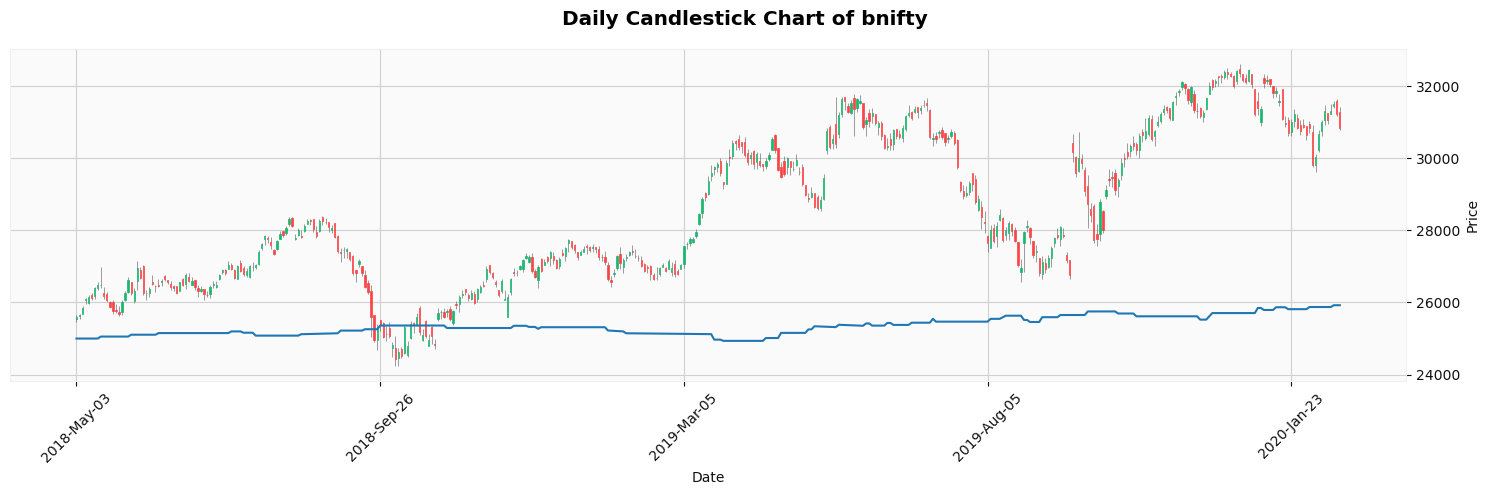

In [199]:
# Creating Subplots
fig, ax = plt.subplots(figsize=(15,5))
mpf.plot(plotbnifty, type='candle', style='yahoo',ax=ax)
plt.plot(bal)
# plt.plot(bnifty[a:]['Date'], bal,'k')
# plt.plot(bnifty[a:]['Date'], bnifty[a:]['sma'])
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('Daily Candlestick Chart of bnifty')
fig.tight_layout()